# CNN for Classification
---
In this notebook, we define **and train** an CNN to classify images from the [Fashion-MNIST database](https://github.com/zalandoresearch/fashion-mnist).

### Load the [data](https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html#fashionmnist)

In this cell, we load in both **training and test** datasets from the FashionMNIST class.

In [84]:
# our basic libraries
from typing import Tuple, List
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt

# data loading and transforming
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from common import Device

In [70]:
# The output of torchvision datasets are PILImage images of range [0, 1]. 
# We transform them to Tensors for input into a CNN

## Define a transform to read the data in as a tensor
data_transform: ToTensor = transforms.ToTensor()

data_dir: str = Path().absolute().joinpath('data').__str__()

# choose the training and test datasets
train_data: FashionMNIST = FashionMNIST(root=data_dir, train=True,
                                   download=True, transform=data_transform)

test_data: FashionMNIST = FashionMNIST(root=data_dir, train=False,
                                  download=True, transform=data_transform)


# Print out some stats about the training and test data
print('Train data, number of images: ', len(train_data))
print('Test data, number of images: ', len(test_data))

Train data, number of images:  60000
Test data, number of images:  10000


In [62]:
# Define a Dataset object for FMNIST data
class FMNISTDataset(Dataset):

    _x: torch.Tensor
    _y: torch.Tensor

    def __init__(self, x: torch.Tensor, y: torch.Tensor) -> None:
        self._x = x
        self._y = y

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        tx, ty = self._x[idx], self._y[idx]
        return tx.to(device=Device), ty.to(device=Device)

    def __len__(self) -> int:
        return len(self._x)

In [87]:
# prepare data loaders, set the batch_size
## TODO: you can try changing the batch_size to be larger or smaller
## when you get to training your network, see how batch_size affects the loss
batch_size: int = 32

train_images, train_labels = train_data.data, train_data.targets
test_images, test_labels = test_data.data, test_data.targets

# Introduce channel dimensions
train_images = torch.unsqueeze(input=train_images, dim=1).type(torch.FloatTensor)
test_images = torch.unsqueeze(input=test_images, dim=1).type(torch.FloatTensor)

train_ds: FMNISTDataset = FMNISTDataset(x=train_images, y=train_labels)
test_ds: FMNISTDataset = FMNISTDataset(x=test_images, y=test_labels)

train_loader: DataLoader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
test_loader: DataLoader = DataLoader(dataset=test_ds, batch_size=len(test_images), shuffle=False)

# specify the image classes
classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Visualize some training data

This cell iterates over the training dataset, loading a random batch of image/label data, using `dataiter.next()`. It then plots the batch of images and labels in a `2 x batch_size/2` grid.

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


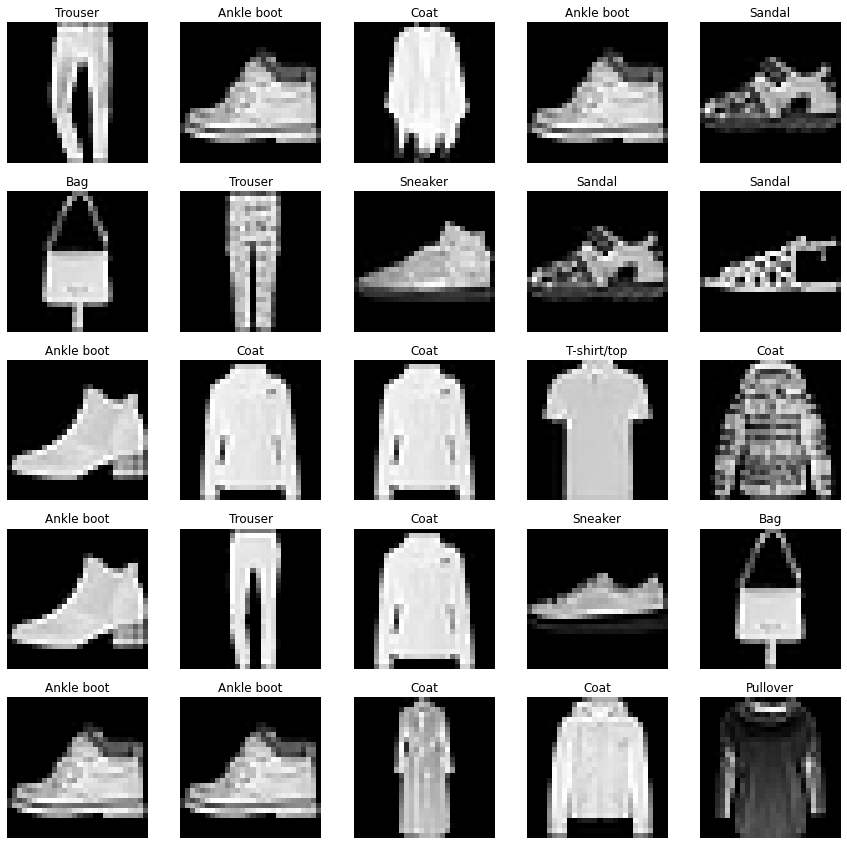

In [64]:
from common import visualize_FMNIST
%load_ext autoreload
%autoreload 2
%matplotlib inline

images, labels = next(iter(train_loader))

# We have to be careful about the grid size. We have loaded a batch of 32 images. 
# Hence the grid_size**2 must be a number lesser than 32.
visualize_FMNIST(x=images.cpu(), y=labels.cpu(), classes=classes, grid_size=5)

### Define the network architecture

The various layers that make up any neural network are documented, [here](http://pytorch.org/docs/master/nn.html). For a convolutional neural network, we'll use a simple series of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected (linear) layers

You are also encouraged to look at adding [dropout layers](http://pytorch.org/docs/stable/nn.html#dropout) to avoid overfitting this data.

---

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

You must place any layers with trainable weights, such as convolutional layers, in the `__init__` function and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, may appear *only* in the `forward` function. In practice, you'll often see conv/pool layers defined in `__init__` and activations defined in `forward`.

#### Convolutional layer
The first convolution layer has been defined for you, it takes in a 1 channel (grayscale) image and outputs 10 feature maps as output, after convolving the image with 3x3 filters.

#### Flattening

Recall that to move from the output of a convolutional/pooling layer to a linear layer, you must first flatten your extracted features into a vector. If you've used the deep learning library, Keras, you may have seen this done by `Flatten()`, and in PyTorch you can flatten an input `x` with `x = x.view(x.size(0), -1)`.

### TODO: Define the rest of the layers

It will be up to you to define the other layers in this network; we have some recommendations, but you may change the architecture and parameters as you see fit.

Recommendations/tips:
* Use at least two convolutional layers
* Your output must be a linear layer with 10 outputs (for the 10 classes of clothing)
* Use a dropout layer to avoid overfitting

In [88]:
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary


class Net(nn.Module):

    conv1: nn.Conv2d
    conv2: nn.Conv2d
    pool1: nn.MaxPool2d
    conv3: nn.Conv2d
    pool2: nn.MaxPool2d
    fc1: nn.Linear

    def __init__(self, num_classes: int) -> None:
        super(Net, self).__init__()
        
        # 1 input image channel (grayscale), 10 output channels/feature maps
        # 3x3 square convolution kernel
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        
        ## TODO: Define the rest of the layers:
        # include another conv layer, maxpooling layers, and linear layers
        # also consider adding a dropout layer to avoid overfitting
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=5 * 5 * 40, out_features=num_classes)
        

    ## TODO: define the feedforward behavior
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = torch.reshape(input=x, shape=(-1, 5 * 5 * 40))
        x = self.fc1(x)
        
        # final output
        return x

# instantiate and print your Net
model: Net = Net(num_classes=len(classes)).to(device=Device)
print(f'Model layers: {model}')
print(f'Model summary: {summary(model=model, input_size=(batch_size, 1, 28, 28))}')

Model layers: Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1000, out_features=10, bias=True)
)
Model summary: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Conv2d: 1-1                            [32, 10, 26, 26]          100
├─Conv2d: 1-2                            [32, 20, 24, 24]          1,820
├─MaxPool2d: 1-3                         [32, 20, 12, 12]          --
├─Conv2d: 1-4                            [32, 40, 10, 10]          7,240
├─MaxPool2d: 1-5         

### TODO: Specify the loss function and optimizer

Learn more about [loss functions](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizers](http://pytorch.org/docs/master/optim.html) in the online documentation.

Note that for a classification problem like this, one typically uses cross entropy loss, which can be defined in code like: `criterion = nn.CrossEntropyLoss()`. PyTorch also includes some standard stochastic optimizers like stochastic gradient descent and Adam. You're encouraged to try different optimizers and see how your model responds to these choices as it trains.


In [89]:
import torch.optim as optim

## TODO: specify loss function (try categorical cross-entropy)
loss_fn: nn.CrossEntropyLoss = nn.CrossEntropyLoss()

## TODO: specify optimizer 
optimizer: optim.Adam = optim.Adam(params=model.parameters(), lr=1e-3)

### A note on accuracy

It's interesting to look at the accuracy of your network **before and after** training. This way you can really see that your network has learned something. In the next cell, let's see what the accuracy of an untrained network is (we expect it to be around 10% which is the same accuracy as just guessing for all 10 classes).

In [90]:
# Calculate accuracy before training
correct = 0
total = 0

# Iterate through test dataset
for images, labels in test_loader:

    # forward pass to get outputs
    # the outputs are a series of class scores
    outputs = model(images)

    # get the predicted class from the maximum value in the output-list of class scores
    _, predicted = torch.max(outputs.data, 1)

    # count up total number of correct labels
    # for which the predicted and true labels are equal
    total += labels.size(0)
    correct += (predicted == labels).sum()

# calculate the accuracy
accuracy = 100 * correct / total

# print it out!
print('Accuracy before training: ', accuracy)

Accuracy before training:  tensor(12.2700, device='cuda:0')


### Train the Network

Below, we've defined a `train` function that takes in a number of epochs to train for. The number of epochs is how many times a network will cycle through the training dataset. 

Here are the steps that this training function performs as it iterates over the training dataset:

1. Zero's the gradients to prepare for a forward pass
2. Passes the input through the network (forward pass)
3. Computes the loss (how far is the predicted classes are from the correct labels)
4. Propagates gradients back into the network’s parameters (backward pass)
5. Updates the weights (parameter update)
6. Prints out the calculated loss



In [68]:
def train(n_epochs: int, model: Net, train_dl: DataLoader, optimizer: optim.Adam, 
        loss_fn: nn.CrossEntropyLoss) -> None:
    """Runs epochs to train the model"""
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss: float = 0.0
        for batch_i, data in enumerate(train_dl):
            # Get the input images and their corresponding labels
            images, labels = data       

            # Zero the parameter (weight) gradients
            optimizer.zero_grad()

            # forward pass to get outputs
            pred: torch.Tensor = model(images)

            # calculate the loss
            loss: torch.Tensor = loss_fn(pred, labels)

            # backward pass to calculate the parameter gradients
            loss.backward()

            # update the parameters
            optimizer.step()

            # print loss statistics
            # to convert loss into a scalar and add it to running_loss, we use .item()
            running_loss += loss.item()
            if batch_i % 1000 == 999:    # print every 1000 mini-batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [91]:
# define the number of epochs to train for
num_epochs: int = 20 # start small to see if your model works, initially

# call train
train(n_epochs=num_epochs, model=model, train_dl=train_loader, optimizer=optimizer, loss_fn=loss_fn)

Epoch: 1, Batch: 1000, Avg. Loss: 0.48597496332228185
Epoch: 2, Batch: 1000, Avg. Loss: 0.29522981468215587
Epoch: 3, Batch: 1000, Avg. Loss: 0.254072108768858
Epoch: 4, Batch: 1000, Avg. Loss: 0.23245119510032236
Epoch: 5, Batch: 1000, Avg. Loss: 0.2283497007433325
Epoch: 6, Batch: 1000, Avg. Loss: 0.20875769329443575
Epoch: 7, Batch: 1000, Avg. Loss: 0.20178861085698008
Epoch: 8, Batch: 1000, Avg. Loss: 0.18872425263002515
Epoch: 9, Batch: 1000, Avg. Loss: 0.17953846469614654
Epoch: 10, Batch: 1000, Avg. Loss: 0.17479701307276263
Epoch: 11, Batch: 1000, Avg. Loss: 0.17016263227630407
Epoch: 12, Batch: 1000, Avg. Loss: 0.16507711810129694
Epoch: 13, Batch: 1000, Avg. Loss: 0.16132010555965826
Epoch: 14, Batch: 1000, Avg. Loss: 0.16284152697678655
Epoch: 15, Batch: 1000, Avg. Loss: 0.15715954048139974
Epoch: 16, Batch: 1000, Avg. Loss: 0.15777136152144522
Epoch: 17, Batch: 1000, Avg. Loss: 0.14636847870284692
Epoch: 18, Batch: 1000, Avg. Loss: 0.15357556791906246
Epoch: 19, Batch: 1000

### Test the Trained Network

Once you are satisfied with how the loss of your model has decreased, there is one last step: test!

You must test your trained model on a previously unseen dataset to see if it generalizes well and can accurately classify this new dataset. For FashionMNIST, which contains many pre-processed training images, a good model should reach **greater than 85% accuracy** on this test dataset. If you are not reaching this value, try training for a larger number of epochs, tweaking your hyperparameters, or adding/subtracting layers from your CNN.

In [92]:
# initialize tensor and lists to monitor test loss and accuracy
test_loss: torch.Tensor = torch.zeros(1)
class_correct: List[int] = list(0. for i in range(10))
class_total: List[int] = list(0. for i in range(10))

# Set the module to evaluation mode
model.eval()

# Iterate over the test batches (a single batch in this case) and predict.
# We have put the model in evaluation mode, hence no grad would be computed 
# and no parameters would be updated.
for batch_i, data in enumerate(test_loader):
    
    # Get the input images and their corresponding labels
    inputs, labels = data
    
    # Forward pass to get outputs
    pred: torch.Tensor = model(inputs)

    # Calculate the loss
    loss: torch.Tensor = loss_fn(pred, labels)
    
    # Update average test loss. In our case we have a single batch. Hence the following 
    # statement is equivalent of computing test_loss += loss.data
    test_loss = test_loss + ((torch.ones(1) / (batch_i + 1)) * (loss.data.cpu() - test_loss))
    
    # Get the predicted class from the maximum value in the output-list of class scores
    _, predicted_class = torch.max(input=pred.data, dim=1)
    
    # Compare predictions to true label
    correct = np.squeeze(predicted_class.eq(labels.data.view_as(predicted_class)))
    
    # Calculate test accuracy for *each* object class
    # we get the scalar value of correct items for a class, by calling `correct[i].item()`
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

print('Test Loss: {:.6f}\n'.format(test_loss.numpy()[0]))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.386182

Test Accuracy of T-shirt/top: 100% ( 2/ 2)
Test Accuracy of Trouser: 100% ( 5/ 5)
Test Accuracy of Pullover: 100% ( 3/ 3)
Test Accuracy of Dress: 100% ( 2/ 2)
Test Accuracy of  Coat: 80% ( 4/ 5)
Test Accuracy of Sandal: 100% ( 3/ 3)
Test Accuracy of Shirt: 100% ( 3/ 3)
Test Accuracy of Sneaker: 66% ( 2/ 3)
Test Accuracy of   Bag: 100% ( 3/ 3)
Test Accuracy of Ankle boot: 66% ( 2/ 3)

Test Accuracy (Overall): 90% (29/32)


### Visualize sample test results

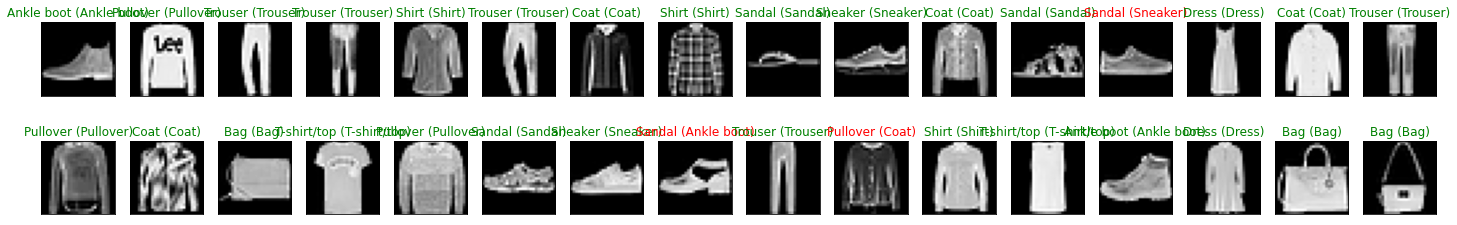

In [93]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
# get predictions
preds = np.squeeze(model(images).data.cpu().max(1, keepdim=True)[1].numpy())
images = images.cpu().numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx] else "red"))

### Question: What are some weaknesses of your model? (And how might you improve these in future iterations.)

**Answer**: The initial model is supposedly performing badly specifically for the foot-wares. From the test result it appears, that model has done specifically poorly in distinguishing between the ankle book and sandal. One idea to mitigate this issue could be use a greater depth of filters to learn more features. We could also try to add few more convolution layers to detect the pattern within patterns.

### Save Your Best Model

Once you've decided on a network architecture and are satisfied with the test accuracy of your model after training, it's time to save this so that you can refer back to this model, and use it at a later data for comparison of for another classification task!

In [ ]:
## TODO: change the model_name to something uniqe for any new model
## you wish to save, this will save it in the saved_models directory
model_dir = 'saved_models/'
model_name = 'model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
# when you're ready, un-comment the line below
# torch.save(net.state_dict(), model_dir+model_name)

### Load a Trained, Saved Model

To instantiate a trained model, you'll first instantiate a new `Net()` and then initialize it with a saved dictionary of parameters (from the save step above).

In [ ]:
# instantiate your Net
# this refers to your Net class defined above
net = Net()

# load the net parameters by name
# uncomment and write the name of a saved model
#net.load_state_dict(torch.load('saved_models/model_1.pt'))

print(net)

# Once you've loaded a specific model in, you can then 
# us it or further analyze it! 
# This will be especialy useful for feature visualization 